In [ ]:
#| default_exp ECMs

# Imports

In [ ]:
#| export
import projective_simulation.methods.transforms as transforms
import numpy as np

from abc import ABC, abstractmethod

# Abstract ECM

In [ ]:
#| export
class Abstract_ECM(ABC):
    """A minimal ECM, every agent should be Derived from this class. Primarily serves to enforce that all ECMs have the "ECM" class

    Examples:
    >>> pass
    """

    def __init__(self, num_actions: int):
        """
        Args:
            ECM: The ECM Object to use
            percept_processor: An optional object for transforming observations prior to passing to ECM as a percept. Must have method "preprocess"
            action_processor: An optional object for transforming actions prior to passing to Environment as an actuator state. Must have method "postprocess"            
        """
        raise NotImplementedError

    @abstractmethod
    def deliberate(self, percept: str):
        """
        Args:
            percept: A string corresponding to an existing or new (will be added) key in the ECM percept dictionary
        """
        raise NotImplementedError

# Two Layer ECMs

## Basic Two Layer

In [ ]:
#| export

class Two_Layer(Abstract_ECM):
    def __init__(self, 
                 num_actions: int, # The number of available actions.
                 glow: float, # The glow (or eta) parameter. 
                 damp: float, # The damping (or gamma) parameter. 
                 softmax: float # The softmax (or beta) parameter.
                ):        
        """
        Simple, 2-layered ECM. We initialize an h-matrix with a single row of `num_actions` 
        entries corresponding to a dummy percept clip being connected to all possible actions with h-values of all 1. We 
        initialize a g-matrix with a single row of `num_actions` entries with all 0s corresponding to the *glow* values 
        of percept-action transitions.

        Percepts must be created from new observations with a preprocessor, e.g. add_percepts
                      
        NOTE: This simple version misses some features such as clip deletion, emotion tags or generalization mechanisms.
        
        """
        self.num_actions = num_actions
        self.glow = glow
        self.damp = damp
        self.softmax = softmax
        #int: current number of percepts.
        self.num_percepts = 0
        #np.ndarray: h-matrix with current h-values. Defaults to all 1.
        self.hmatrix = np.ones([1,self.num_actions])
        #np.ndarray: g-matrix with current glow values. Defaults to all 0.
        self.gmatrix = np.zeros([1,self.num_actions])
        #dict: Dictionary of percepts as {"percept": index}
        self.percepts = {}

    def deliberate(self, percept: str):
        """
        Given a percept, returns an action and changes the ECM if necessary
        First, if the percept is new, it will be added to the ECM
        Then, an action is selected as a function of the percept and the h-values of edges connected to that percept
        Finally, the g-matrix is updated based on the realized percept-action pair.
        """
        #Add percept to ECM if not already present
        self.add_percept(percept)
        #Perform Random Walk
        # get index from dictionary entry
        percept_index = self.percepts[percept]
        # get h-values
        h_values = self.hmatrix[percept_index]
        # get probabilities from h-values through a softmax function
        prob = transforms._softmax(self.softmax, h_values)
        # get action
        action = np.random.choice(range(self.num_actions), p=prob)        
        #pdate g-matrix
        self.gmatrix[int(percept_index),int(action)] = 1.
        return action

    def add_percept(self, percept):
        '''
        Checks if percept is in dictionary and adds to ECM in not
        '''
        if percept not in self.percepts.keys(): 
            self.percepts[percept] = self.num_percepts
            # increment number of percepts
            self.num_percepts += 1
            # add column to h-matrix
            self.hmatrix = np.append(self.hmatrix, 
                                     np.ones([1,self.num_actions]),
                                     axis=0)
            # add column to g-matrix
            self.gmatrix = np.append(self.gmatrix, 
                                    np.zeros([1,self.num_actions]),
                                    axis=0)

    def learn(self, reward):
        """
        Given a reward, updates h-matrix. Updates g-matrix with glow.
        """
        # damping h-matrix
        self.hmatrix = self.hmatrix - self.damp*(self.hmatrix-1.)
        # update h-matrix
        self.hmatrix += reward*self.gmatrix
        # update g-matrix
        self.gmatrix = (1-self.glow)*self.gmatrix

## Priming Two Layer

In [ ]:
#| export

class Priming_ECM(Two_Layer):
    '''
    This sub-class of the Two-Layer ECM adds a variable for action priming.
    This variable should be a list of floats, each element of which corresponds to an action in the ECM.
    These "priming values" are summed with h-values of any edge connected to the associated action node prior to calculating walk probabilites with the softmax function
    '''
    def __init__(self, 
                 num_actions: int, # The number of available actions.                 
                 glow: float = 0.1, # The glow (or eta) parameter. 
                 damp: float = 0.01, # The damping (or gamma) parameter. 
                 softmax: float = 0.5, # The softmax (or beta) parameter.
                 action_primes: list = None, #weights on the probability that deliberation steps into each action. Defaults to 0 for each action 
                ):
        if action_primes is None:
            action_primes = [0.] * num_actions
        assert len(action_primes) == num_actions
        super().__init__(num_actions, glow, damp, softmax)
        self.action_primes = action_primes
        

    def deliberate(self, percept):
        '''
        Almost identical to the deliberate function of Two-Layer parent class, but sums h-values and action primes prior to calculating walk probabilities
        '''
        self.add_percept(percept)
        #Perform Random Walk
        # get index from dictionary entry
        percept_index = self.percepts[percept]
        # get h-values
        h_values = self.hmatrix[percept_index]
        #~~~Differences from two-layer deliberate function within
        assert len(h_values) == len (self.action_primes)
        # get probabilities from h-values and primes through a softmax function
        prob = transforms._softmax(self.softmax, h_values + self.action_primes)
        #~~~~~~~
        # get action
        action = np.random.choice(range(self.num_actions), p=prob)        
        #pdate g-matrix
        self.gmatrix[int(percept_index),int(action)] = 1.
        return action

#### Example

[<matplotlib.lines.Line2D>]

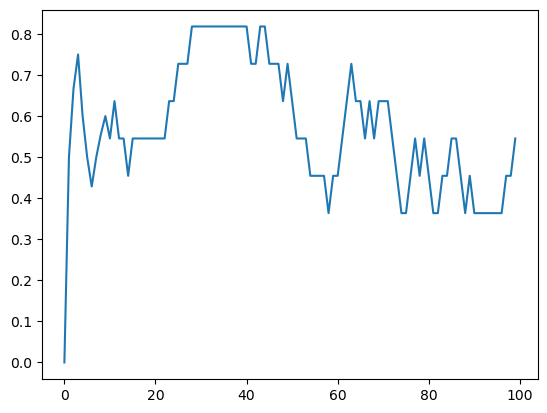

In [ ]:
#|eval : false
from projective_simulation.environments import RLGL
from projective_simulation.ECMs import Priming_ECM

import matplotlib.pyplot as plt

test_ECM = Priming_ECM(num_actions = 2, action_primes = [0., 1.5])
#Number of steps to run simulation
T = 100
data_log = [None] * T
env = RLGL() #create a default red-light-green-light environment

for t in range(T):
    observation = env.get_observation()
    action = test_ECM.deliberate(observation)
    reward = env.get_reward(action)
    test_ECM.learn(reward)
    data_log[t] = {"env_state": env.state, "action": action, "reward": reward}
    env.transition(action)

plt.plot(range(T), [np.mean([data_log[step]["reward"] for step in range(i-10,i+1) if step >= 0]) for i in range(T)]) #plot a 10 step moving average of the reward 

## Episodic ECM

In [ ]:
#| export

class Episodic_Memory(Abstract_ECM):
    def __init__(self,
                 num_actions: int, # the number of perceptual representations available to the agent which, when excited, have an effect on the agent's environment. Action representations are primed differently than sensory representations and do not affect surprise
                 capacity: int = 10, # the number of memory traces avaiable to the agent. If simulation time exceeds capacity, the oldest memory trace will be overwritten each time step
                 softmax: float = 1, # used to determine random walk probabilities, edge weights are normalized using a softmax function with this variable as the temperature constant
                 focus: float = 0., #Focus scales the effect of stochastic processes underlying random walks on the ECM. (i.e. it scales the effect of Projective Simulation)
                                    #Think of deliberation in an Episodic ECM like a very large number of particles diffusing on the ECM graph, but at each node a single particle is chosen at random and some proportion of particles are pulled along with that one. Focus defines that proportion
                                    #If focus == 1, deliberation acts as a random walk of a single (massive) particle on the ECM. 
                                    #If focus == 0, deliberation acts as the diffusion of a large (approaching infinite) number of particles on the ECM
                 kappa: float = 1., #How strongly the agent discounts the similarity between two states per bit of mismatched sensory information when establishing a new belief state
                 intrinsic_expectations: dict = None, #If a key in this dictionary corresponds to an index of the agent's perceptual representations, the items value will be added to that percepts expectation value during the agent's predictions. Agents will seek out states that excite perceptual representations with intrinsic expectation
                 epsilon: float = 0.01,  # a baseline value for the priming of perceptual representations. Must be greater than 0 to prevent infinite surprise if a perceptual representation is excited that was not predicted by the agents belief state. Note this will be transormed by the logistic function, so entropy calculations are not done using precisely this number
                 deliberation_length: int = 1,   # deliberation_length: the number of diffusive steps in the agent's deliberations
                 t: int = 0, #used to model the temporal excitation sequence of memory traces
                 expectation_scale: float = 3 #A logistic function is used to scale percept priming between zero and one. This default rate parameter keeps the function used approximately linear when the input is between 0.1 and 0.8
                ):
        '''
        The episodic memory ECM stores percept information in a time ordered system of memory traces by establishing connections (trace_encoder) with weights (hmatrix) between excited perceptual representations and an excited memory trace.
        The agent maintains a belief state through the activation (different from excitation) of memory traces, where the strength of activation reflects the strength of the agent's belief that its current state-in-the-world is effectively the same as a state-in-the-world represented by that memory trace
        The agent also maintains an expectation state by priming perceptual representations as a function of (1) its belief state, (2) connections between memory traces (mmatrix, stricly time-ordered in this implementation), and (3) the h-matrix
        The difference between the agent's expectation state and the excitation of perceptual represenations in the next time step is computed as a surprise and assigned to the last excited memory trace as a valence state
        Perceptual representations are excited as a function of sensory-motor interactions with the world and the agent's expectation state
        Memory Traces are excited in a time-ordered, winner-takes all fashion.
        The agent's beliefs are updated by a process of deliberation, in which excited perceptual representations are activated and those activations then diffuse across the ECM as if they were caused by particles performing a random walk on the ECM graph
        The probability that an activation particle walks from one node to another is a function of the edge weights in the hmatrix connected to its current node (perceptual representation or memory trace), and the belief states and valence states of all nodes to which those edges lead
        The focus parameter of the Episodic ECM adds weight to a single departing edge from each node, adding stochastic bias to the random walk. Rewards reinforce edge weights in the ECM proportionally to the difference between the expected particle mass to traverse that edge and the observed mass
        Rewards are determined as a function of the "surprise advantage", i.e. how much more or less surprised the agent was then on average over its previous (relevant) experience.
        '''

        #initialize constants
        self.num_actions = num_actions
        self.capacity = capacity
        self.softmax = softmax
        self.focus = focus 
        self.kappa = kappa
        self.intrinsic_expectations = {} if intrinsic_expectations is None else intrinsic_expectations
        self.epsilon = epsilon
        self.deliberation_length = deliberation_length
        self.surprise: float = None
        self.expectation_scale = expectation_scale
        
        #initialize modelling variables
        self.t = t

        #initialize ECM states
        self.hmatrix = np.zeros((self.num_actions, self.capacity)) #weights connecting percept nodes to trace nodes
        self.mmatrix = np.zeros((self.capacity, self.capacity)) #initialize with no connections between memory traces
        self.trace_encoder = np.zeros((self.num_actions, self.capacity), dtype = 'bool') #boolean matrix indicating whether a percept node was encoded in a trace
        self.action_encoder = np.ones(self.num_actions, dtype = 'bool') #boolean matrix indicated whether a percept node belongs to an action
        self.expectations = np.zeros(self.num_actions)
        self.beliefs = np.zeros(self.capacity) #initilize with no belief weight on any memory traces
        self.valences = np.array([np.nan] * self.capacity) #use nan here because we will want to takes means of this array as it is filled
        self.percept_activations = np.zeros(np.shape(self.hmatrix)[0]) #initialize with no activation of percept nodes
        self.trace_activations = np.zeros(self.capacity) #initialize with no activation of memory traces
        self.trace_excitations = np.zeros(self.capacity) #trace excitations represent the sensory evidence that the world is currently in a state that is effectively represented by the excited trace
        

    def deliberate(self, percept):
        self.add_percept(percept)
        self.surprise = self.get_surprise(percept)
        self.excite_traces(percept)
        self.encode_trace(percept)
        self.activate()
        for deliberation_step in range(self.deliberation_length):
            self.diffuse_activation()
        self.predict()
        self.t = (self.t + 1) % self.capacity
        return(self.expectations[self.action_encoder]) #return action priming

    def add_percept(self, percept):
        if len(percept) > np.shape(self.hmatrix)[0]: #if percept is longer than the first dimension of the hmatrix it means there is something new in the observation (handled by preprocessor)
            i = np.shape(self.hmatrix)[0] #get index for new elements in ECM
            new_elements = percept[i:len(percept)]    
            self.hmatrix = np.append(self.hmatrix, np.zeros((len(new_elements), self.capacity)), axis = 0) #add baseline weights to connections between new percept nodes and all traces
            self.trace_encoder = np.append(self.trace_encoder, np.zeros((len(new_elements), self.capacity), dtype = 'bool'), axis = 0) #new percept nodes have no existing connections to trace nodes
            self.action_encoder = np.append(self.action_encoder, np.zeros(len(new_elements), dtype = 'bool')) #this ECM does not support new actions, so new percept nodes are sensory by default
            self.expectations = np.append(self.expectations, np.array([transforms._shifted_exp(0,0, epsilon = self.epsilon) for x in range(len(new_elements))])) #sets new expectation states the same as existing sensory representations not predicted by deliberation
            
    def excite_traces(self, percept):
        self.trace_excitations = np.zeros(self.capacity)
        # each trace is excited proportionally to the probability that of the n connections it has to perceptual representations, each of those perceptual representations are excited . . .
        # . . . if that trace effectively represents the current world state . . .
        # . . . a logistic transfomation of connecting edge gives the probability that a sensory representation fails to excite when the world is in the state represented by the memory trace.
        for t_index in range(self.capacity):
            connections = [i for i in range(np.shape(self.trace_encoder)[0]) if self.trace_encoder[i,t_index]] #indexes of percept nodes with connections to memory trace
            if np.sum(connections) > 0: #no excitation if trace has no connections (functionally this shouldn't matter, but it is nicer for interpretation)
                #we fill the likelihoods vector
                excitation_probs = transforms._logistic(self.hmatrix[connections,t_index], k = self.kappa)
                likelihoods = excitation_probs**percept[connections] * ((1-excitation_probs)**(1-percept[connections])) #probabilities of Bernoulli trials with outcome equal to the excitation of connected percept nodes
                self.trace_excitations[t_index] = np.prod(likelihoods)
    
    def encode_trace(self, percept):
        self.trace_encoder[0:,self.t] = [x > 0 for x in percept] #connect all excited percepts to current trace
        self.hmatrix[0:,self.t] = percept #h-values of edges are set to excitation of connected representation
        self.mmatrix[self.t-1,self.t] = 1 #create forward connection from previous trace to current trace (this is a spurious but inconsequential connection for an agent's first step)
        self.mmatrix[self.t,0:] = [0 for x in self.mmatrix[self.t,0:]] #break any forward connections from current trace (only relevant if t is greater than self.capacity)
        self.valences[self.t-1] = self.surprise #valence is assigned to the last trace, it relfects how surprised the agent was by the outcome of the action it took in that trace
    
    def activate(self):
        activation_weights = transforms._softmax(self.softmax, self.hmatrix[self.trace_encoder[0:,self.t],self.t]) #softmax function over edge weights connected to current memory trace
        random_selection = np.random.choice(range(len(activation_weights)), p = activation_weights) #get destination of PS random walk
        self.percept_activations = np.zeros(np.shape(self.hmatrix)[0]) #reset activations
        #bias activation toward starting node of PS random walk
        self.percept_activations[self.trace_encoder[0:,self.t]] = [activation_weights[i] + self.focus*(1-activation_weights[i]) if i == random_selection else activation_weights[i] * (1-self.focus) for i in range(len(activation_weights))]

    def diffuse_activation(self):
        new_percept_activations = np.zeros(np.shape(self.hmatrix)[0])
        new_trace_activations = np.zeros(self.capacity)
        #get diffusion from percept nodes
        for i in range(np.shape(self.hmatrix)[0]):
            #edge weights are the product of the the edge h-values exponent (relevance), the prior expectation of the trace to which the edge is connected (belief prior), and the excitation of the trace to which the edge is connected (sensory evidence)
            edge_weights = self.hmatrix[i,self.trace_encoder[i,0:]] * self.beliefs[self.trace_encoder[i,0:]] * self.trace_excitations[self.trace_encoder[i,0:]]
            if len(edge_weights) > 0: #dont diffusion activation if there are no edges (there should not be to activation to diffuse)
                edge_probs = transforms._softmax(self.softmax, edge_weights)
                random_selection = np.random.choice(range(len(edge_weights)), p = edge_probs) #get destination of Projective Simulations
                diffusion_mass = _get_diffusion_mass(self.percept_activations[i], edge_probs, random_selection, self.focus)
                new_trace_activations[self.trace_encoder[i,0:]] = new_trace_activations[self.trace_encoder[i,0:]] + diffusion_mass
        #get diffusion from memory traces
        for n in range(np.shape(self.hmatrix)[1]):
            #edge weights are the product of the the edge h-values exponent (relevance), the activation of the trace to which the edge is connected (belief prior), and the excitation of the trace to which the edge is connected (sensory evidence)
            edge_weights = np.exp(self.hmatrix[self.trace_encoder[0:,n],n])
            if len(edge_weights) > 0: #dont diffuse activation if there are no edges (there should not be to activation to diffuse)    
                edge_probs = transforms._softmax(self.softmax, edge_weights)
                random_selection = np.random.choice(range(len(edge_weights)), p = edge_probs) #get destination of Projective Simulations
                diffusion_mass = _get_diffusion_mass(self.trace_activations[n], edge_probs, random_selection, self.focus)
                new_percept_activations[self.trace_encoder[0:,n]] = new_percept_activations[self.trace_encoder[0:,n]] + diffusion_mass
        self.percept_activations = new_percept_activations
        self.trace_activations = new_trace_activations

    def predict(self):
        self.beliefs = np.matmul(self.trace_activations, self.mmatrix) # because each row of the matrix has either zeros or a single 1, this just propogates attention forward. non-linear functions might be necessary for more complex mmatrix structures
        self.expectations = np.zeros(np.shape(self.hmatrix)[0]) #hmatrix rows correspond to perceptual representations
        for trace in range(self.capacity):
            priming_scalers =  np.log(np.nanmean(self.valences)/self.valences)  #used to scale priming of action representations as a function of trace valence
            priming_scalers[np.isnan(priming_scalers)] = 0 #traces without valence do not prime (including current trace)
            #add to the expectation weight of each percept node the expectation weight of the given trace times the weight of its connection to that percept node times the priming scaler (set to one if the given percept nodes is a sensory representation)
            self.expectations = self.expectations + self.beliefs[trace] * transforms._logistic(self.hmatrix[0:,trace], k = self.kappa) * self.trace_encoder[0:,trace] * priming_scalers[trace] ** self.action_encoder # final term sets priming to scale to 1 if the percept node is a sensory representation
        intrinsics = np.array([intrinsic_expectations.values()[i] if i in self.intrinsic_expectations.keys() else 0 for i in range(np.shape(self.hmatrix)[0])]) #not sure whether this is nice/faster than maintaining a vector of intrinsic expectations that has zeros added whenever a new sensory representation is created?
        self.expectations = np.array([transforms._shifted_exp(x = self.expectations[i], k = intrinsics[i], epsilon = self.epsilon) for i in range(len(self.expectations))]) # right now this has the property of slightly changing action priming. Could easily just exclude action representations from this operation, but maybe there is a more elegant solution?
        
    def get_surprise(self, percept):
        not_action = np.invert(self.action_encoder) #used to exclude action representations from surprise computations
        return np.sum(np.where(percept[not_action], -np.log2(self.expectations[not_action]), -np.log2(1-self.expectations[not_action])))
            
def _get_diffusion_mass(activation, edge_probs, random_selection, focus):
    #gets the activation mass that diffuses along each edge connected to a perceptual representation. Note the different effect of the focus parameter if the edge was selected by PS random walk
    diffusions = [None] * len(edge_probs)
    for i in range(len(edge_probs)):
        if i == random_selection:
            diffusions[i] = activation * (edge_probs[i] + focus*(1-edge_probs[i]))
        else:
            diffusions[i] = activation * edge_probs[i] * (1 - focus)
    return(diffusions)  